In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [3]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
#DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml


/home/gizatt/miniconda2/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Env  0 :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Env  1 :  [0. 0. 0. 0. 0. 0.]
Env  2 :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Env  3 :  [0. 0. 0. 0. 0. 0.]
Env  4 :  [0. 0. 0. 0. 0. 0.]
Env  5 :  [0. 0. 0. 0. 0. 0.]
Env  6 :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


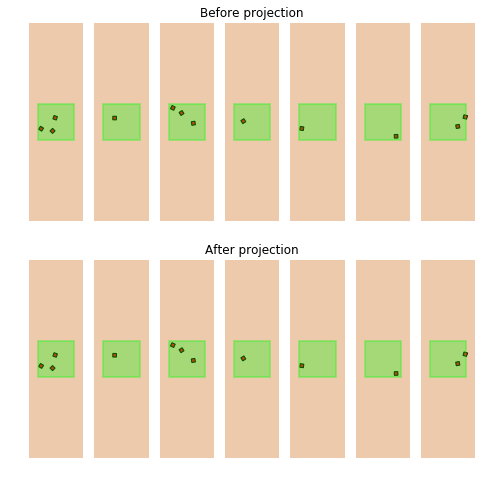

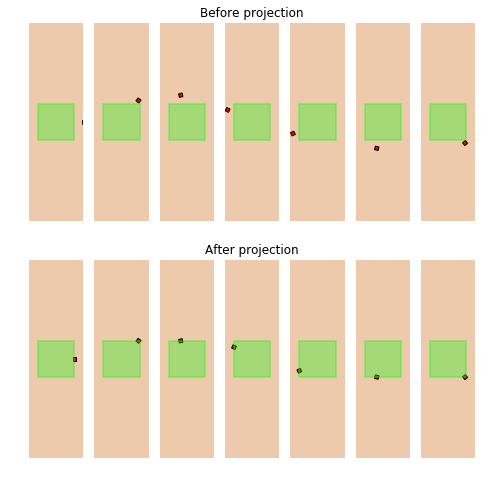

In [4]:
# Illustrate a few example scenes from the training set
import generate_planar_scene_arrangements as psa_utils
import differentiable_nlp as diff_nlp
from copy import deepcopy

def draw_rbt(ax, rbt, q):
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)
    
def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    draw_rbt(ax, rbt, q)
    

# Try out the projection stuff on examples that shouldn't project
plt.figure().set_size_inches(8, 2)
N = 7
for k in range(N):
    plt.subplot(2, N, 1+k)
    env_i = deepcopy(environments[k])
    rbt, q = psa_utils.build_rbt_from_summary(env_i)
    draw_rbt(plt.gca(), rbt, q)
    if k == np.floor(N/2):
        plt.title("Before projection")
    plt.subplot(2, N, 1+k+N)
    q_proj, info, dqf_dq0, _ = diff_nlp.projectToFeasibilityWithIK(
        rbt, q,
        [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
            np.zeros(3), np.ones(3))])
    print "Env ", k, ": ", q_proj - q
    draw_rbt(plt.gca(), rbt, q_proj)
    if k == np.floor(N/2):
        plt.title("After projection")
    #plt.tight_layout()
    
# And random examples that will definitely need projection
plt.figure().set_size_inches(8, 2)
N = 7
base_bad_env = {
    "n_objects": 1,
    "obj_0000": {
        "class": "small_box",
        "pose": np.array([0.5, 0.5, 0])
    }
}
for k in range(N):
    plt.subplot(2, N, 1+k)
    env_i = deepcopy(base_bad_env)
    ang = (float(k)/N)*np.pi*2.
    env_i["obj_0000"]["pose"] += np.array([.75*np.cos(ang), .75*np.sin(ang), ang])
    rbt, q = psa_utils.build_rbt_from_summary(env_i)
    draw_rbt(plt.gca(), rbt, q)
    if k == np.floor(N/2):
        plt.title("Before projection")
    plt.subplot(2, N, 1+k+N)
    q_proj, info, dqf_dq0, _ = diff_nlp.projectToFeasibilityWithIK(
        rbt, q,
        [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
            np.zeros(3), np.ones(3))])
    draw_rbt(plt.gca(), rbt, q_proj)
    if k == np.floor(N/2):
        plt.title("After projection")
    #plt.tight_layout()
    

Selection of environments from original distribution


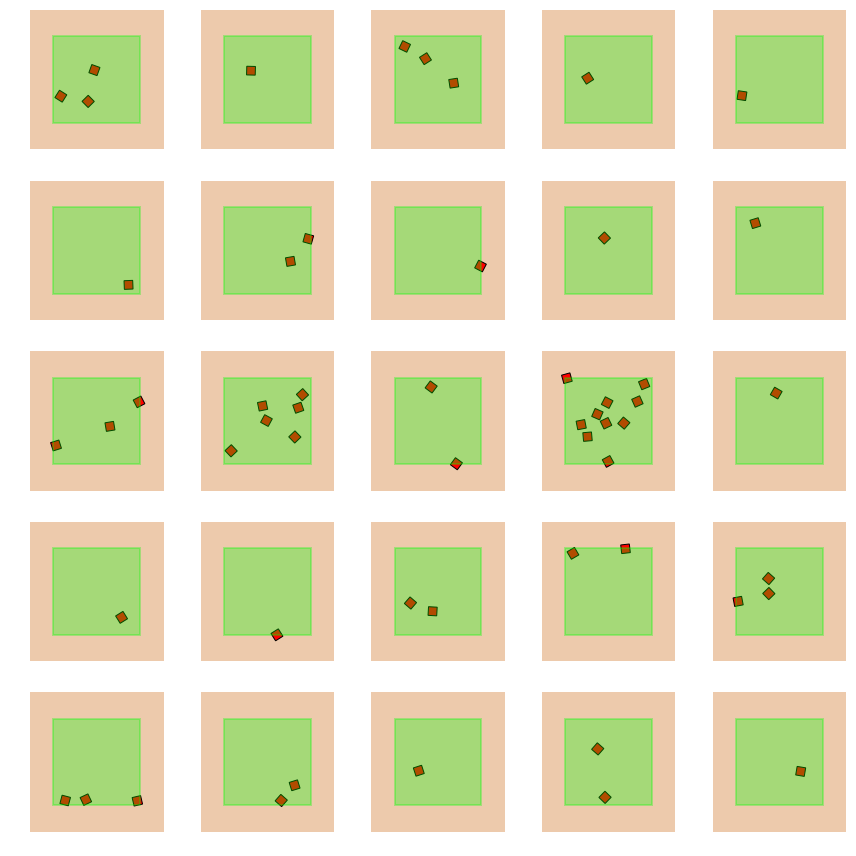

In [5]:
# Illustrate a few example scenes from the training set

plt.figure().set_size_inches(12, 12)
print "Selection of environments from original distribution"
N = 5
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments[i*N+j], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [6]:
from collections import namedtuple

def expand_partial_pose_to_full_pose(this_pose):
    full_poses = torch.zeros(this_pose.shape[0], 6,
                             requires_grad=False,
                             dtype=this_pose.dtype)
    full_poses[:, 0] = this_pose[:, 0]
    full_poses[:, 1] = this_pose[:, 1]
    full_poses[:, 5] = this_pose[:, 2]
    return full_poses

def collapse_full_pose_to_partial_pose(pose):
    partial_pose = torch.zeros(pose.shape[0], 3, requires_grad=False,
                       dtype=pose.dtype)
    partial_pose[:, 0] = pose[:, 0]
    partial_pose[:, 1] = pose[:, 1]
    partial_pose[:, 2] = pose[:, 5]
    return partial_pose

VectorizedEnvironments = namedtuple("VectorizedEnvironments",
    ["idents", "poses", "present", "n_samples"], verbose=False)
def vectorize_environments(envs):
    # Vectorization into a 
    # poses (order x y theta) and
    # idents (ci) per object
    n_environments = len(envs)
    poses = torch.Tensor(n_environments, MAX_NUM_OBJECTS*3)
    poses[:, :] = 0.
    idents = torch.LongTensor(n_environments, MAX_NUM_OBJECTS)
    idents[:, :] = 0
    present = torch.Tensor(n_environments, MAX_NUM_OBJECTS)
    present[:, :] = 0
    n_samples = torch.Tensor(n_environments)
    n_samples[:] = 0
    for i, env in enumerate(envs):
        n_samples[i] = env["n_objects"]
        for k in range(MAX_NUM_OBJECTS):
            if k < env["n_objects"]:
                obj = env["obj_%04d" % k]
                idents[i, k] = object_class_to_index[obj["class"]]
                poses[i, (k*3):(k*3+3)] = torch.Tensor(obj["pose"])
                present[i, k] = 1
    return VectorizedEnvironments(
        idents=idents, poses=poses,
        present=present, n_samples=n_samples)
    
def devectorize_environments(data):
    if not isinstance(data, VectorizedEnvironments):
        raise ValueError("Expected VectorizedEnvironments input")
    envs = []
    for i in range(data.idents.shape[0]):
        env = {}
        n_objects = 0
        for k in range(data.n_samples[i]):
            obj = {
                "pose": data.poses[i, (k*3):(k*3+3)].cpu().detach().numpy(),
                "class": object_classes[data.idents[i, k].cpu().detach().item()]
            }
            env["obj_%04d" % k] = obj
        env["n_objects"] = data.n_samples[i]
        envs.append(env)
    return envs

Write our generator in Pyro, as an iterative procedure:

~~~python
# Start out with an "empty" environment
num_steps = choose_num_steps()
env = []
for k in range(num_steps):
    # Pick an object to spawn
    ci = sample_object_class(env)
    # Pick where to put it
    env = sample_object_placement(ci, env)
    # Make that placement feasible
    env = project_env_to_feasibility(env)
~~~

In [7]:
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
#torch.manual_seed(101);

pyro.enable_validation(True)

object_classes = ["small_box"]
object_class_to_index = {}
for i, obj in enumerate(object_classes):
    object_class_to_index[obj] = i
n_object_classes = len(object_classes)

def sample_object_class(generated_data, i, keep_going, obs=None):
    # For now, single object class, so this is trivial.
    # Down the road, the category probs will need to depend on env
    # in some way.
    return poutine.mask(lambda: pyro.sample("%d_class_assignment" % i,
                        dist.Categorical(torch.Tensor([1.0])),
                        obs=obs), keep_going)()

# Prior distributions for each object class over the ground
class ObjectWorldPriorDescription:
    def __init__(self, ci):
        # (maybe switch this to Normal-inverse-Wishart_distribution, if supported?)
        self.mean = pyro.sample('%s_mean' % object_classes[ci], dist.Normal(
            torch.Tensor([0.5, 0.5, np.pi]), torch.Tensor([0.5, 0.5, np.pi/2.])).to_event(1))
        self.var = pyro.sample('%s_var' % object_classes[ci], dist.LogNormal(
            torch.Tensor([0.0, 0.0, 0.0]), torch.Tensor([2.0, 2.0, 2.0])).to_event(1))
        self.dist = dist.MultivariateNormal(self.mean, torch.diag(self.var))
    def vectorize():
        raise NotImplementedError()
        return torch.Tensor([])


rbts_cache = {}
def build_rbt_from_generated_row_and_new_object(generated_data, row_i, iter_i, ci):
    # Build a descriptor string to check into the cache
    # "<obj 0 class>_<obj 1 class>_<...>
    present = generated_data.present[row_i, 0:iter_i+1].cpu().detach().numpy()
    present[-1] = 1.
    if not np.allclose(present, 1.):
        return None
    previous_object_classes = generated_data.idents[row_i, 0:iter_i+1].cpu().detach().numpy()
    previous_object_classes[-1] = ci[row_i]
    class_string = "_".join([object_classes[cj] for cj in previous_object_classes])
    
    if class_string not in rbts_cache.keys():
        # Cache miss, generate the RBT
        env = {"n_objects": iter_i+1}
        for iter_j in range(iter_i+1):
            env["obj_%04d" % iter_j] = {
                "class": object_classes[previous_object_classes[iter_j]],
                "pose": np.zeros(3)
            }
        new_rbt, _ = psa_utils.build_rbt_from_summary(env)
        rbts_cache[class_string] = new_rbt

    return rbts_cache[class_string]
    
    
def sample_object_placement(ci, generated_data, i, keep_going, object_world_prior_params, obs=None):
    # TODO: figure out how to do a broadcast-select of this.
    # I could use index_select if I stacked the params into a Tensor,
    # I just need to abandon my nice data structure...
    prior_info = object_world_prior_params[0]
    new_pose = pyro.sample('location_pre_%d' % (i), prior_info.dist)
    '''
    new_pose = poutine.mask(
        lambda: pyro.sample('location_pre_%d' % (i), prior_info.dist, obs=obs),
        keep_going)()
    return new_pose
    '''
    if i > 0: 
        q0_fixed = torch.cat([
            expand_partial_pose_to_full_pose(
                generated_data.poses[:, (k*3):(k*3+3)]) for k in range(i)],
            dim=-1)
    else:
        q0_fixed = None

    # Build an RBT for each row in the batch...
    rbts = [build_rbt_from_generated_row_and_new_object(
                generated_data, k, i, ci) for k in range(generated_data.poses.shape[0])]
    
    # Constrain free poses to have y,z,roll,pitch constant
    ik_constraints = [diff_nlp.object_at_specified_pose_constraint_constructor_factory(
        i, np.array([0., 0., 0.5, 0., 0., 0.]), np.array([1., 1., 0.5, 0., 0., 2*np.pi]))]
    projection_dist = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
        rbts, expand_partial_pose_to_full_pose(new_pose),
        ik_constraints, 0.05, 0.01, noisy_projection=False,
        q0_fixed=q0_fixed)
    
    if obs is not None:
        data_obs = expand_partial_pose_to_full_pose(obs)
    else:
        data_obs = None
    projected_pose = poutine.mask(
        lambda: pyro.sample("location_post_%d" % (i), projection_dist, obs=data_obs),
        keep_going)()
    return projected_pose[:, [0, 1, 5]]

MAX_NUM_OBJECTS = 10    
def sample_keep_going(generated_data, i, falloff_rate, obs=None):
    return pyro.sample('keep_going_%d' % i,
                        dist.Bernoulli(falloff_rate),
                        obs=obs)

# Each row of "data" is a vectorized
# description of an environment.
# To make these rows constant size, all vectorizations
# are the same length, but padded with "null objects"
# up to a max number of objects. This is inspired by
# the handling of the Pyro AIR example.

def model(data=None, subsample_size=None):
    i = 0
    keep_going = True
    
    object_world_prior_params = []
    for i in range(n_object_classes):
        object_world_prior_params.append(
            ObjectWorldPriorDescription(i)
        )
        
    sample_rates = pyro.sample('num_objects_weights', dist.Dirichlet(torch.ones(MAX_NUM_OBJECTS+1)))
    sample_distribution = dist.Categorical(sample_rates)
    
    # Generate in vectorized form for easier batch conversion at the end
    n = 1
    if data:
        if not isinstance(data, VectorizedEnvironments):
            raise ValueError("Expected VectorizedEnvironments input")
        if (data.idents.shape[1] != MAX_NUM_OBJECTS and
           data.poses.shape[1] != MAX_NUM_OBJECTS*3):
            raise ValueError("Got unexpected data shape.")
        n = data.idents.shape[0]
    if subsample_size is None:
        subsample_size = n
    # Who knows why, but pyro's subsampling wasn't being random during SVI.
    # Someone somewhere might be resetting internal RNG state.
    # Here I force RNG from the torch RNG.
    indices = torch.randperm(n)[0:subsample_size]
    with pyro.plate('data', subsample_size):
        generated_data = VectorizedEnvironments(
            idents=torch.LongTensor(subsample_size, MAX_NUM_OBJECTS),
            poses=torch.Tensor(subsample_size, MAX_NUM_OBJECTS*3),
            present=torch.Tensor(subsample_size, MAX_NUM_OBJECTS),
            n_samples=torch.Tensor(subsample_size))
        generated_data.idents[:, :] = -1
        generated_data.poses[:, :] = 0
        generated_data.present[:, :] = 0
        generated_data.n_samples[:] = 0

        # Sample actual number of samples immediately
        gt_n_samples = None
        if data is not None:
            gt_n_samples = data.n_samples[indices]
        num_samples = pyro.sample("num_samples", sample_distribution,
                                  obs=gt_n_samples)
        generated_data.n_samples[:] = num_samples
        
        for i in range(MAX_NUM_OBJECTS):
            gt_class = None
            gt_location = None
            gt_keep_going = None
            if data is not None:
                gt_class = data.idents[indices, i]
                gt_location = data.poses[indices, (i*3):(i*3+3)]
                gt_keep_going = data.present[indices, i]
                
            keep_going = (i < num_samples)
            ci = sample_object_class(generated_data, i, keep_going, gt_class)
            location = sample_object_placement(ci, generated_data, i, keep_going, object_world_prior_params, gt_location)
            
            # Fill in generated data appropriately
            generated_data.idents[:, i] = ci.view(-1).type(torch.long)*keep_going.type(torch.long)
            for k in range(3):
                generated_data.poses[:, 3*i+k] = torch.Tensor(location[:, k])*keep_going.type(torch.float)
            generated_data.present[:, i] = keep_going
    return generated_data
print model()

VectorizedEnvironments(idents=tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), poses=tensor([[0.2459, 1.0000, 1.7864, 0.0000, 1.0000, 1.3926, 0.4702, 0.9694, 2.0012,
         0.0000, 0.6587, 1.9979, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]]), present=tensor([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]]), n_samples=tensor([4.]))


Selection of environments from prior / generative model


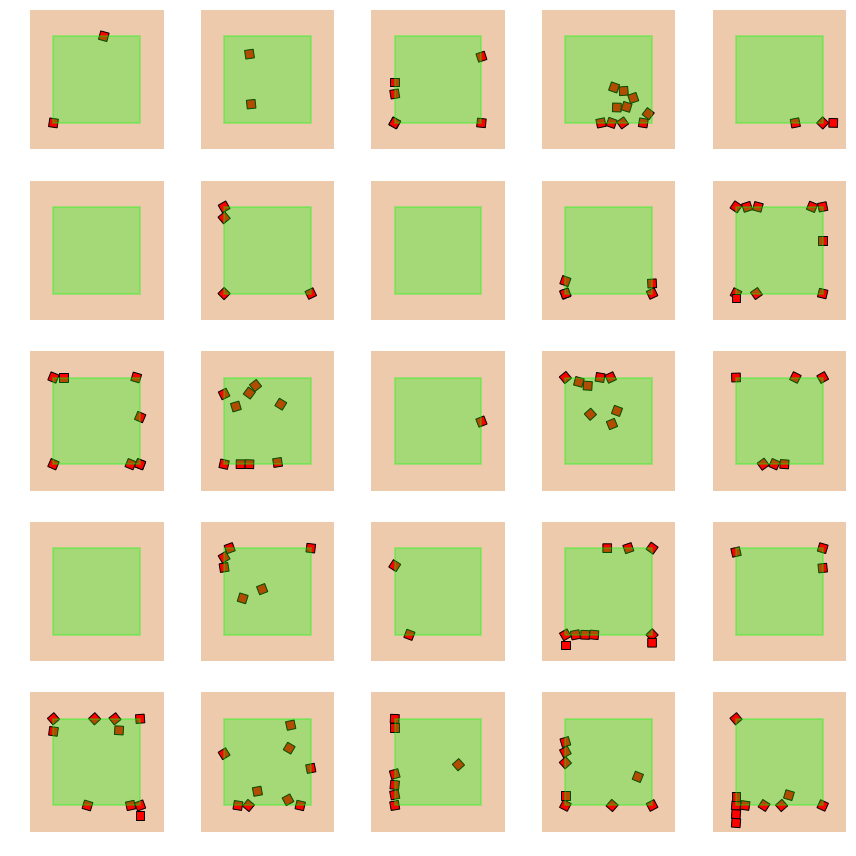

In [8]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(devectorize_environments(model())[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [9]:
# Rig for SVI.
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal

pyro.enable_validation(True)

interesting_params = ["small_box_mean", "small_box_var", "num_objects_weights"]
def select_interesting(guide):
    all_params = global_guide.median()
    return dict((p, all_params[p]) for p in interesting_params)

pyro.clear_param_store()
global_guide = AutoDiagonalNormal(
    poutine.block(model, hide=["obs"]))
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.98]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)
losses = []
data = vectorize_environments(environments)




snapshots = {}
for i in range(501):
    loss = svi.step(data, subsample_size=50)
    losses.append(loss)
    snapshot_median = global_guide.median()
    for p in snapshot_median.keys():
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(snapshot_median[p].cpu().detach().numpy().copy())
    if (i % 10 == 0):
        print ".",
    if (i % 50 == 0):
        print "\n"
        print select_interesting(global_guide)
print "Done"


. 

{'small_box_var': tensor([0.9048, 1.1052, 0.9048], grad_fn=<AddBackward0>), 'small_box_mean': tensor([-0.1000,  0.1000, -0.1000], grad_fn=<ViewBackward>), 'num_objects_weights': tensor([0.0830, 0.1003, 0.0991, 0.0978, 0.0964, 0.0802, 0.0818, 0.0973, 0.0940,
        0.0808, 0.0893], grad_fn=<MulBackward0>)}
. . . . . 

{'small_box_var': tensor([1.6506, 1.5630, 2.3671], grad_fn=<AddBackward0>), 'small_box_mean': tensor([0.1455, 0.1810, 0.6467], grad_fn=<ViewBackward>), 'num_objects_weights': tensor([0.0194, 0.5151, 0.2066, 0.0955, 0.0423, 0.0311, 0.0197, 0.0152, 0.0145,
        0.0193, 0.0212], grad_fn=<MulBackward0>)}
. . . . . 

{'small_box_var': tensor([1.0612, 1.2277, 2.7152], grad_fn=<AddBackward0>), 'small_box_mean': tensor([0.2543, 0.2741, 1.4438], grad_fn=<ViewBackward>), 'num_objects_weights': tensor([0.0119, 0.4047, 0.2504, 0.1388, 0.0625, 0.0344, 0.0227, 0.0239, 0.0112,
        0.0155, 0.0239], grad_fn=<MulBackward0>)}
. . . . . 

{'small_box_var': tensor([0.8531, 0.9185, 

In [10]:
# Optional additional steps, repeat as necessary...
for i in range(201):
    loss = svi.step(data, subsample_size=20)
    losses.append(loss)
    snapshot_median = global_guide.median()
    for p in snapshot_median.keys():
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(snapshot_median[p].cpu().detach().numpy().copy())
    if (i % 10 == 0):
        print ".",
    if (i % 50 == 0):
        print "\n"
        print select_interesting(global_guide)
print "Done"

IndexError: index 20 is out of bounds for dimension 0 with size 20

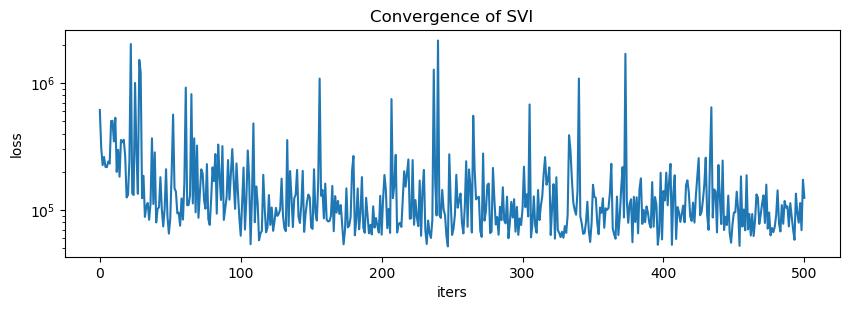

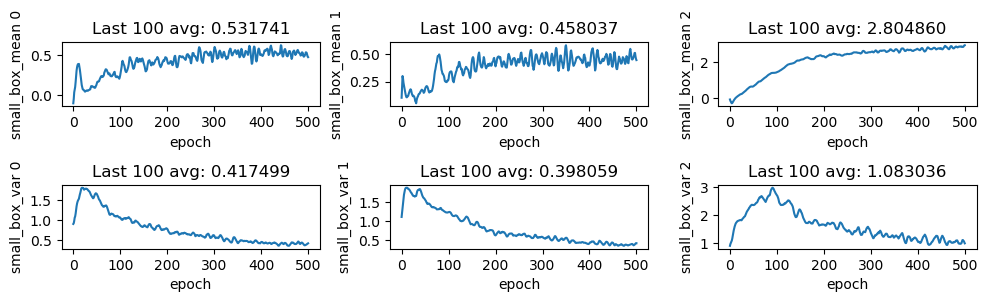

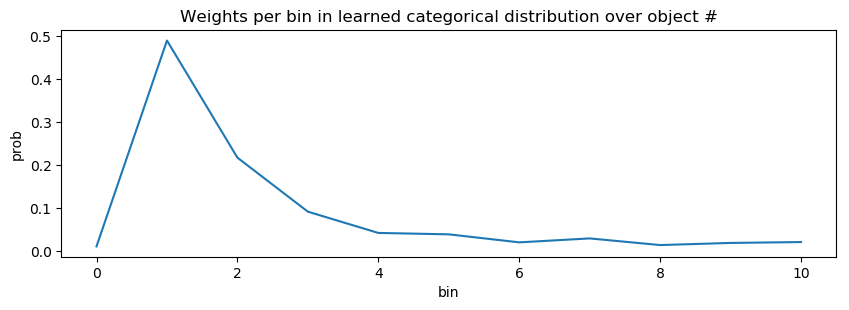

In [11]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
#print global_guide.median()

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
keys = ["small_box_mean", "small_box_var"]
fit_vals = {}
n_plots = len(keys)
for i, key in enumerate(keys):
    data_across_epochs = np.vstack(snapshots[key])
    for k in range(3):
        plt.subplot(n_plots, 3, i*3+k+1)
        start_epoch = 0
        plt.plot(np.arange(start_epoch, data_across_epochs.shape[0]), data_across_epochs[start_epoch:, k])
        plt.xlabel('epoch')
        plt.ylabel(key + " %d" % k)
        plt.title("Last 100 avg: %f" % data_across_epochs[-100:, k].mean())
    fit_vals[key] = data_across_epochs[-100:].mean(axis=0)
plt.tight_layout()

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(global_guide.median()["num_objects_weights"].cpu().detach().numpy())
plt.xlabel('bin')
plt.ylabel('prob')
plt.title('Weights per bin in learned categorical distribution over object #');

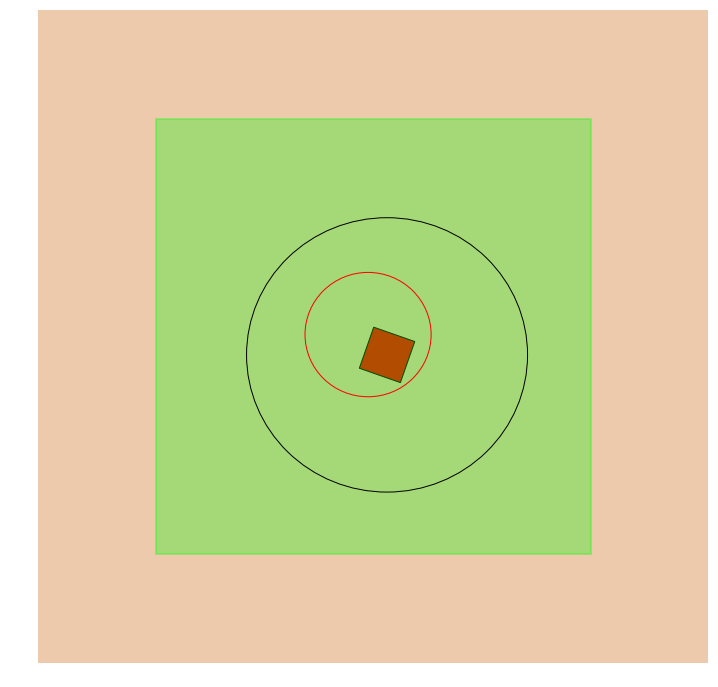

In [13]:
from matplotlib.patches import Ellipse
plt.figure().set_size_inches(12, 12)

# get all occurances of each object class + get real mean + var
occurances_by_object = {}
for n in object_classes:
    occurances_by_object[n] = []
for env in environments:
    for k in range(env["n_objects"]):
        obj = env["obj_%04d"%k]["class"]
        occurances_by_object[obj].append(env["obj_%04d"%k]["pose"])
real_vals = {}
for n in object_classes:
    occurances = np.vstack(occurances_by_object[n])
    real_vals[n + "_mean"] = occurances.mean(axis=0)
    real_vals[n + "_var"] = np.square(occurances.std(axis=0))


env = {"n_objects": n_object_classes}
for k in range(n_object_classes):
    object_name = object_classes[k]
    env["obj_%04d" % k] = {"class": object_name, "pose": fit_vals[object_name + "_mean"]}
# One object of each class, right at its mean
draw_environment(env, plt.gca())
# And draw ellipses
for k in range(n_object_classes):
    object_name = object_classes[k]
    var = fit_vals[object_name + "_var"]
    mean = fit_vals[object_name + "_mean"]
    lambda_ = np.sqrt(var)
    ell = Ellipse(xy=mean[0:2],
                  width=lambda_[0], height=lambda_[1],
                  color='black')
    ell.set_facecolor('none')
    plt.gca().add_artist(ell)
    
    var = real_vals[object_name + "_var"]
    mean = real_vals[object_name + "_mean"]
    lambda_ = np.sqrt(var)
    ell = Ellipse(xy=mean[0:2],
                  width=lambda_[0], height=lambda_[1],
                  color='red')
    ell.set_facecolor('none')
    plt.gca().add_artist(ell)
plt.show()

In [ ]:
plt.figure().set_size_inches(24, 24)
print "Selection of environments from prior / generative model"
N = 7

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        sample = poutine.condition(model, data=select_interesting(global_guide))()
        draw_environment(devectorize_environments(sample)[0], plt.gca())
        plt.grid(True)
plt.tight_layout()